**EL SIGUIENTE MODELO DE SERIE TEMPORAL SE CONSTRUIRÁ UTILIZANDO LA HERRAMIENTA DE FACEBOOK PROPHET**

Traemos todas las librerias a utilizarse en el presente modelo + los datos que se han copiado directamente de google drive donde se encuentra guardado el csv de los datos del consumo de energía del Cluster 15 correspondiente a un tipo de consumidores de Energía de Irlanda.

In [352]:

!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install statsmodels
!pip install pandas
!pip install Prophet


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import numpy as np

from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation


# Cargamos primero el contenido de nuestro Drive
from google.colab import drive

drive.mount('/content/drive')

# Cargamos el conjunto de datos y lo definimos dentro del nombre df ( dataframe de pandas)

df = pd.read_csv('/content/drive/MyDrive/cluster15.csv', delimiter=';',parse_dates=['ds'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d_%H'))

df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d_%H')

#leo los heads de mi dataframe para validar que se haya cargado correctamente
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-352-da2a86832981>:28: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/drive/MyDrive/cluster15.csv', delimiter=';',parse_dates=['ds'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d_%H'))


,ds,y
0,2009-07-15 00:00:00,1.090514
1,2009-07-15 01:00:00,0.781937
2,2009-07-15 02:00:00,0.595129
3,2009-07-15 03:00:00,0.531196
4,2009-07-15 04:00:00,0.502776


**PREPARACIÓN DE DATOS**

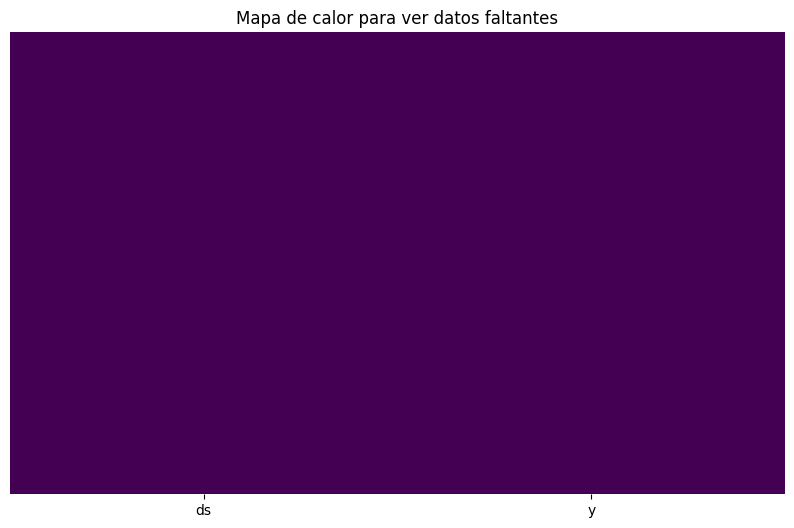

In [353]:
#Vamos a evaluar los datos para conocer si tenemos datos faltantes
#una buena tecnica para evaluarlo correctamente es hacer un mapa de calor

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Mapa de calor para ver datos faltantes')
plt.show()

Vemos que el mapa de calor no muestra datos faltantes así que seguimos con nuestro análisis y modelo.

**EVALUACION DE LOS DATOS PARA ANALIZAR TEMPORALIDADES Y ESTACIONALIDADES**

In [354]:
#Resumen estadistico de nuestros datos
print(df.describe())

                                  ds             y
count                          12196  12196.000000
mean   2010-04-08 11:57:46.874385152      1.210797
min              2009-07-15 00:00:00      0.445080
25%              2009-11-25 06:45:00      0.721158
50%              2010-04-08 06:30:00      1.264845
75%              2010-08-20 14:15:00      1.519938
max              2010-12-31 23:00:00      3.355223
std                              NaN      0.493110


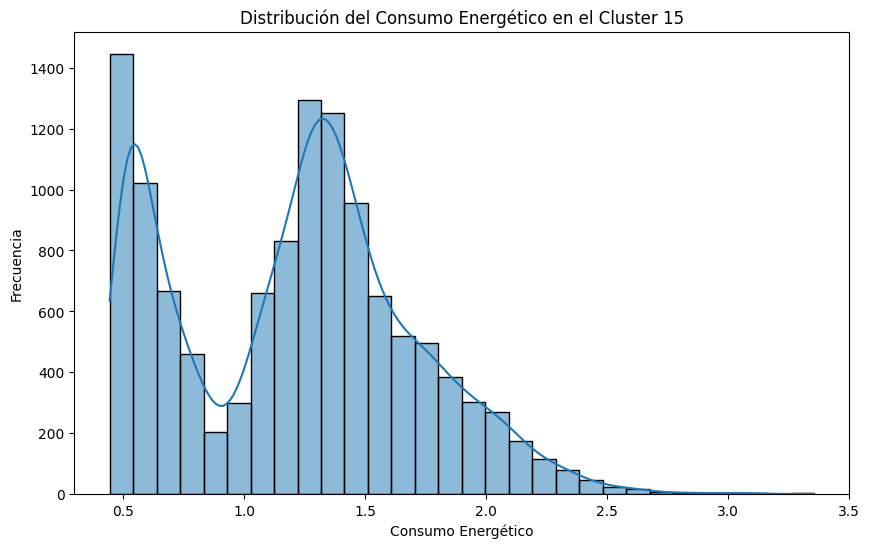

In [355]:
# Vamos a visualizar como está la distribución del consumo energético en este cluster
plt.figure(figsize=(10, 6))
sns.histplot(df['y'], bins=30, kde=True)
plt.title('Distribución del Consumo Energético en el Cluster 15')
plt.xlabel('Consumo Energético')
plt.ylabel('Frecuencia')
plt.show()

Vemos que nuestro diagrama tiene una cola considerable hacia puntos de consumo cercanos a 3.5 Kwh, sugiriendo que posible tenemos outliers en nuestros datos que deberiamos tomarlo en consideración al momento de evaluar nuestro modelo.


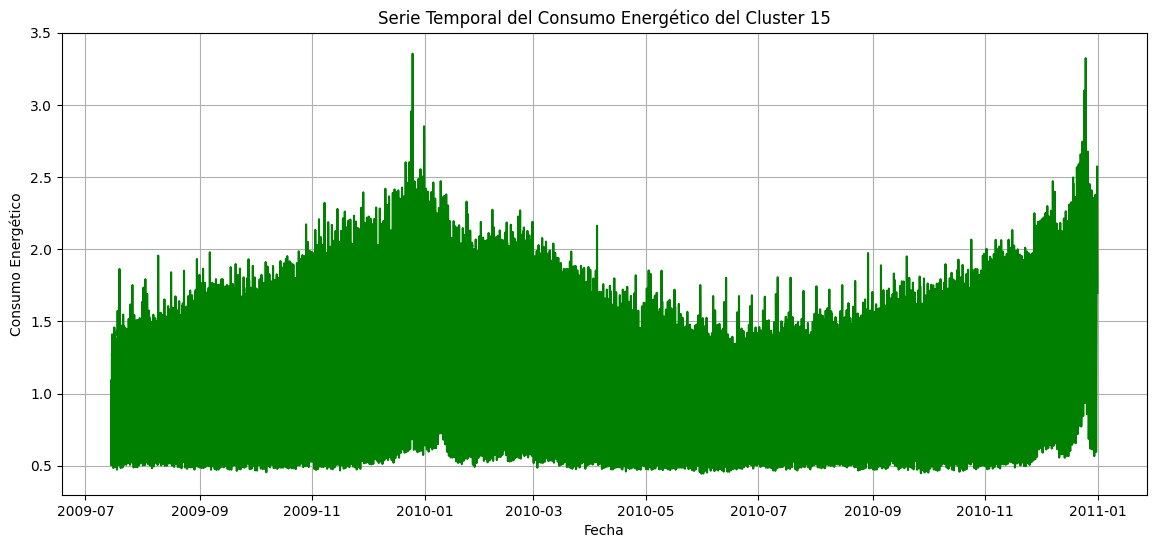

In [356]:
# Vamos a revisar y visualidar como se compone la serie temporal de este cluster
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], color='green')
plt.title('Serie Temporal del Consumo Energético del Cluster 15')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético')
plt.grid(True)
plt.show()

Vemos que tenemos algunos outliers, de consumos en momentos picos qaue deben ser algunas festividades de Irlanda. Las mantendremos estandar en el modelo ya que prophet trabaja muy bien mitigando estos outliers.

**DIVISION DEL MODELO ENTRE EL CONJUNTO DE PRUEBA Y ENTRENAMIENTO**

In [357]:
#dividimos los datos en 2 grupos para entrenar sobre un conjunto de datos y probar el modelo sobre otro.
#lo entrenaremos sobre el 80% y lo probaremos con el 20% restante
df['ds'] = pd.to_datetime(df['ds'])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=30)

In [358]:
#Antes de continuar reviso que se hayan dividio correctamente validando su tamaño
print(len(df))
print(len(train_df))
print(len(test_df))

#esta todo ok

12196
9756
2440


**CREACIÓN DE NUESTRO MODELO SOBRE EL CONJUNTO DE ENTRANIMIENTO :**

In [373]:

#creo la variable m que tendrá como componente principal Prophet de la biblioteca de Facebook para ajustar a los datos de las
#series temporales
#podemos la escala en 0.01 por que queremos que el modelo sea relativamente flexible y sencible a cambios de tendencia
#nuestro modelot tomará en cuenta la tendencia de estacionalidad, anual, semanal y diaria. Inclusive tendrá en consideración el impacto de las festividades que hemos identificado en puntos anteriores.

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    )


In [374]:
#utilizamos el metodo fit para ajustar el data frame bajo el metodo de series temporales definido en m,
#lo hacemos sobre la data de entrenamiento

m.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpky155lcb/n0v25cgh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky155lcb/wsma96we.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73402', 'data', 'file=/tmp/tmpky155lcb/n0v25cgh.json', 'init=/tmp/tmpky155lcb/wsma96we.json', 'output', 'file=/tmp/tmpky155lcb/prophet_model1spk17_i/prophet_model-20240425171757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [375]:
           # Creaamos un DataFrame con fechas futuras para hacer predicciones.
#Es importante mencionar que la frecuencia de nuestros datos son horario por ello la "H"
#vamos a predecir un mes en rango horario

future_dates = m.make_future_dataframe(periods=len(test_df), freq='H')
print(future_dates)

                       ds
0     2009-07-15 00:00:00
1     2009-07-15 01:00:00
2     2009-07-15 02:00:00
3     2009-07-15 03:00:00
4     2009-07-15 06:00:00
...                   ...
12191 2011-04-12 11:00:00
12192 2011-04-12 12:00:00
12193 2011-04-12 13:00:00
12194 2011-04-12 14:00:00
12195 2011-04-12 15:00:00

[12196 rows x 1 columns]


**VISUALIZACIÓN DEL MODELO**

In [376]:
#proyecto el forecast de mi modelo para las fechas determinadas en el punto anterior
forecast = m.predict(future_dates)

print(forecast)

                       ds     trend  yhat_lower  yhat_upper  trend_lower  \
0     2009-07-15 00:00:00  1.227160    0.383884    1.634469     1.227160   
1     2009-07-15 01:00:00  1.227155    0.419246    1.623425     1.227155   
2     2009-07-15 02:00:00  1.227151    0.496153    1.628211     1.227151   
3     2009-07-15 03:00:00  1.227147    0.444372    1.613114     1.227147   
4     2009-07-15 06:00:00  1.227134    0.439153    1.639654     1.227134   
...                   ...       ...         ...         ...          ...   
12191 2011-04-12 11:00:00  1.228870    0.554691    1.716865     1.226991   
12192 2011-04-12 12:00:00  1.228875    0.552473    1.707257     1.226995   
12193 2011-04-12 13:00:00  1.228879    0.533142    1.776360     1.226998   
12194 2011-04-12 14:00:00  1.228884    0.524484    1.757791     1.227002   
12195 2011-04-12 15:00:00  1.228889    0.590560    1.718129     1.227005   

       trend_upper  additive_terms  additive_terms_lower  \
0         1.227160       -0

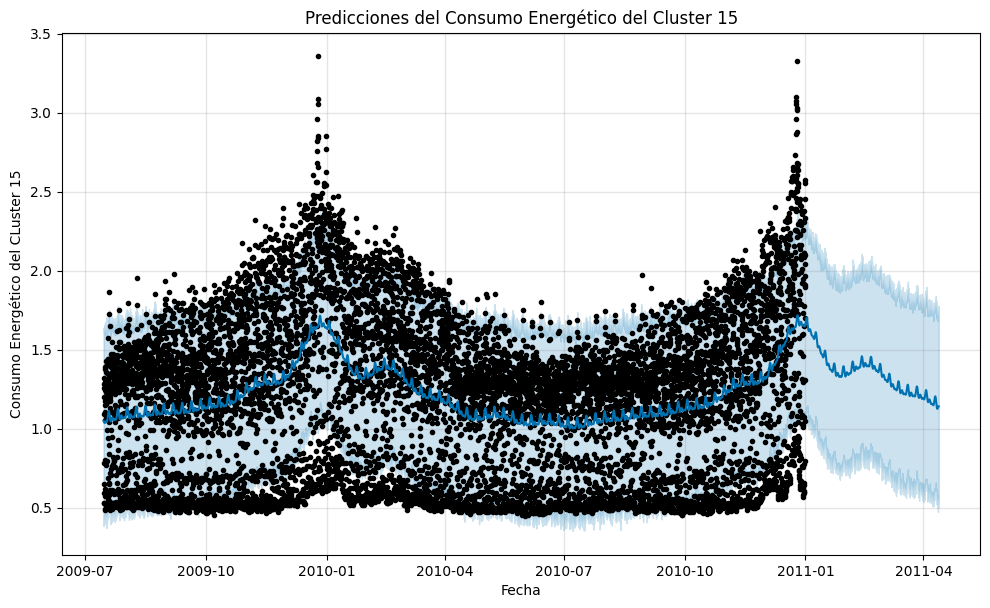

In [377]:
# A continuación vamos a visualizar las predicciones realizadas en el punto anterior
fig1 = m.plot(forecast)
plt.title('Predicciones del Consumo Energético del Cluster 15')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético del CLuster 15')
plt.show()

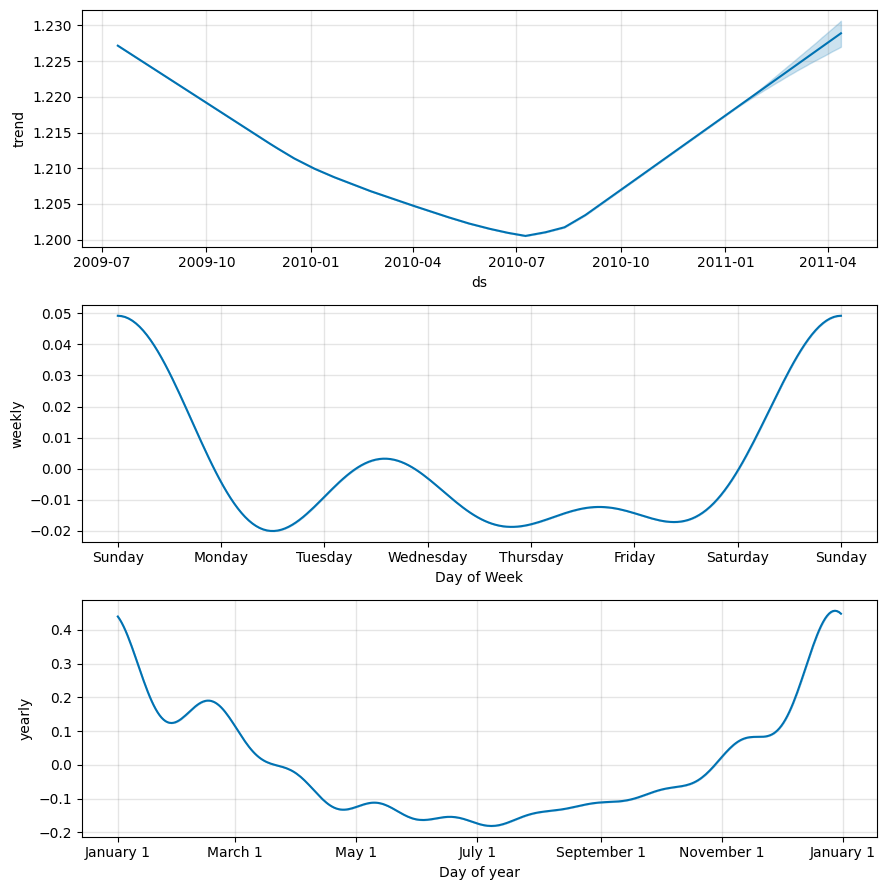

In [378]:
#con el modelo realizado ahora vamos a revisar sus componenete para evaluarlo
fig2 = m.plot_components(forecast)
plt.show()

**:::EVALUACIÓN DEL MODELO ☢**

In [379]:
# Calculamos  las métricas de evaluación
# Definimos los valores reales del consumo energético en el conjunto de prueba
y_test =test_df['y']
# Definimos las predicciones del consumo energético
y_predict = forecast['yhat'][-len(y_test):]

#Elegimos 3 metricas para evaluar nuestro modelo MAE , MSE y RMSE
# Error medio absoluto (MAE)
mae = np.mean(np.abs(y_test - y_predict))

# Error cuadrático medio (MSE)
mse = np.mean((y_test - y_predict) ** 2)

# Raíz del error cuadrático medio (RMSE)
rmse = np.sqrt(mse)

print("Error Medio Absoluto (MAE):", mae)
print("Error Cuadrático Medio (MSE):", mse)
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)

Error Medio Absoluto (MAE): 0.481126284578232
Error Cuadrático Medio (MSE): 0.3406784432867322
Raíz del Error Cuadrático Medio (RMSE): 0.5836766598783373


El modelo evaluado sobre el conjunto de prueba muestra una MAE, MSE y RMSE bajos. Esto nos muestra que el modelo selección Prophet tiene un bien rendimiento y debería considerarse como una buena opción para predecir el consumo energético de este cluster 15.

DIAGNOSTICO DEL MODELO MEDIANTE VALIDACIÓN CRUZADA

In [380]:
# Procedemos a realizar validación cruzada
df_cv = cross_validation(m, initial='180 days', period='60 days', horizon='30 days')

# Calcular métricas de rendimiento
df_p = performance_metrics(df_cv)

# Ahora vemos el rendimiento del modelo
print(df_p)

INFO:prophet:Making 6 forecasts with cutoffs between 2010-02-04 23:00:00 and 2010-12-01 23:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpky155lcb/ppvf85r_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky155lcb/bc9kqt_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66420', 'data', 'file=/tmp/tmpky155lcb/ppvf85r_.json', 'init=/tmp/tmpky155lcb/bc9kqt_j.json', 'output', 'file=/tmp/tmpky155lcb/prophet_modelc64x1b77/prophet_model-20240425171805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky155lcb/bkda2mvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky155lcb/_2hw6feu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

             horizon       mse      rmse       mae      mape     mdape  \
0    3 days 02:00:00  0.207177  0.455167  0.378240  0.444200  0.240915   
1    3 days 03:00:00  0.208696  0.456832  0.380234  0.447933  0.242593   
2    3 days 04:00:00  0.211339  0.459716  0.382434  0.453479  0.242593   
3    3 days 05:00:00  0.215262  0.463963  0.385661  0.464162  0.242593   
4    3 days 06:00:00  0.216155  0.464924  0.386241  0.465683  0.242593   
..               ...       ...       ...       ...       ...       ...   
641 29 days 20:00:00  0.253359  0.503348  0.401034  0.509832  0.217025   
642 29 days 21:00:00  0.254590  0.504569  0.402378  0.510368  0.217490   
643 29 days 22:00:00  0.255315  0.505287  0.403406  0.510867  0.217908   
644 29 days 23:00:00  0.255660  0.505628  0.403965  0.511242  0.218349   
645 30 days 00:00:00  0.255143  0.505117  0.402824  0.509972  0.217490   

        smape  coverage  
0    0.336737  0.768293  
1    0.339027  0.762195  
2    0.341631  0.756098  
3    0.

In [381]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-05 00:00:00,1.463574,0.812220,2.085477,1.224568,2010-02-04 23:00:00
1,2010-02-05 01:00:00,1.463878,0.795485,2.059928,0.853317,2010-02-04 23:00:00
2,2010-02-05 02:00:00,1.464018,0.872625,2.076956,0.690537,2010-02-04 23:00:00
3,2010-02-05 03:00:00,1.464012,0.826368,2.092442,0.587566,2010-02-04 23:00:00
4,2010-02-05 04:00:00,1.463881,0.859638,2.072097,0.549265,2010-02-04 23:00:00


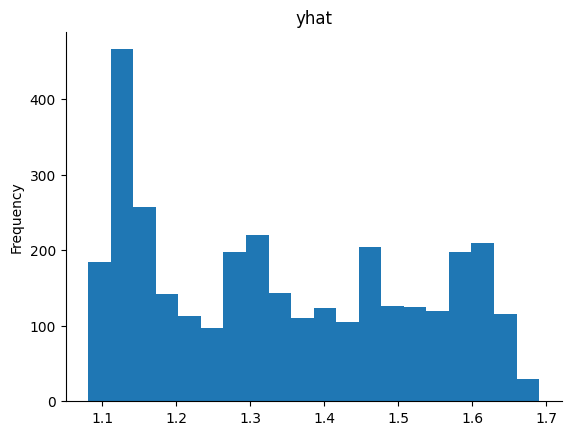

In [382]:
# @title yhat

from matplotlib import pyplot as plt
df_cv['yhat'].plot(kind='hist', bins=20, title='yhat')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [383]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days 02:00:00,0.207177,0.455167,0.378240,0.444200,0.240915,0.336737,0.768293
1,3 days 03:00:00,0.208696,0.456832,0.380234,0.447933,0.242593,0.339027,0.762195
2,3 days 04:00:00,0.211339,0.459716,0.382434,0.453479,0.242593,0.341631,0.756098
3,3 days 05:00:00,0.215262,0.463963,0.385661,0.464162,0.242593,0.346323,0.746951
4,3 days 06:00:00,0.216155,0.464924,0.386241,0.465683,0.242593,0.346848,0.746951


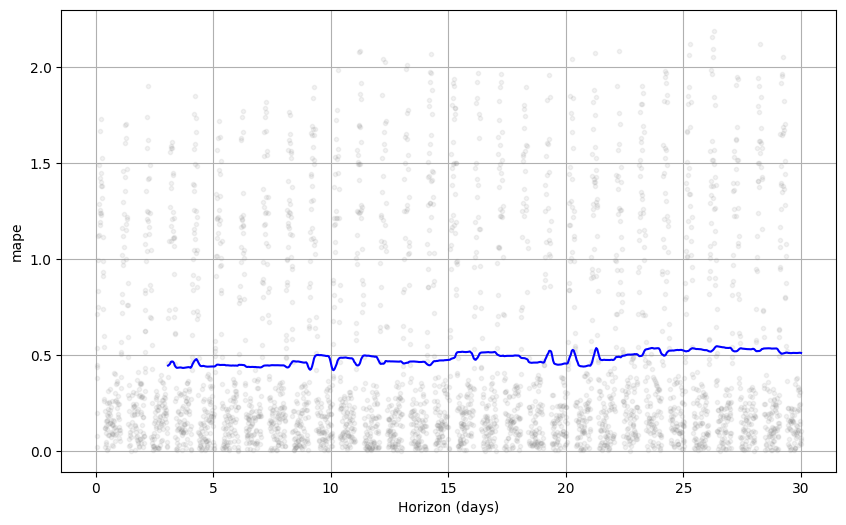

In [384]:
from prophet.plot import plot_cross_validation_metric
fig4= plot_cross_validation_metric(df_cv, metric='mape')

In [385]:
from sklearn.metrics import r2_score
r2 = r2_score(test_df['y'], y_predict)
print('R^2:', r2)

R^2: -0.15503400212440788


Este plot demuestra que conforme queremos hacer proyecciones para varios días estos pueden no ser precisos. Hasta aproximadamente 10 días de proyección tendremos un buen desenvolvimiento del modelo. Sin embargo, si decidimos hacer hasta 30 días de forecast sería relativamente preciso ( mape menos a 0.3); pero potencialmente deberiamos incluir otras variables al modelo para hacerlo más preciso.

FUTUROS PASOS PARA MEJORAR EL MODELO.
"TUNEAR" LOS HIPERPARAMETROS DEL MISMO COMO LA SCALE QUE SE DETERMINÓ EN UN INICIO EN 0.01, PODRIAMOS ITERAR CUALES PODRIAN SER LOS MEJORES VALORES PARA DETERMINAR LA ESCALA DE LA ESTACIONALIDAD Y DE SENCIBILIDAD DEL MODELO.
https://facebook.github.io/prophet/docs/diagnostics.html


**CONCLUSIONES DEL MODELO**
Vemos que el MSE es muy reducido lo cual demuestra que el modelo
parecía ser accurate para la proyección que estamos construyendo

El RMSE es relativamente bajo ( 0.17) indicando un buen rendimiento del modelo

En promedio tenemos un MAE (Mean Absolute Error) relativamente bajo (0.12) indicando poca diferencia absoluta entre las predicciones y los valores reales de nuestro serie temporal.

De acuerdo al modelo creado el 82-83% de las predicciones realizadas contienen valores reales, lo cuales brindan una fiabilidad elevada del modelo. Se podría ajustar posteriormente modificando los parámetros del mismo.
